In [8]:
import sys 
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
sys.path.insert(0, "../../")
import spycone as spy
import subprocess

# Gene-level workflow

## Prepare the dataset

We use a time series dataset of influenza infection with 9 time points. 

In [9]:
#sample data
subprocess.call("wget https://zenodo.org/record/7228475/files/normticonerhino_wide.csv?download=1 -O normticonerhino_wide.csv", shell=True)


influ = pd.read_csv("normticonerhino_wide.csv")
flu_ts = influ.iloc[:,3:] ##filter out the entrez id and gene id column

--2022-10-20 12:22:45--  https://zenodo.org/record/7228475/files/normticonerhino_wide.csv?download=1
Resolving zenodo.org (zenodo.org)... 188.184.117.155
Connecting to zenodo.org (zenodo.org)|188.184.117.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16468278 (16M) [text/plain]
Saving to: ‘normticonerhino_wide.csv’

     0K .......... .......... .......... .......... ..........  0% 2,64M 6s
    50K .......... .......... .......... .......... ..........  0% 1,86M 7s
   100K .......... .......... .......... .......... ..........  0%  129M 5s
   150K .......... .......... .......... .......... ..........  1% 4,99M 4s
   200K .......... .......... .......... .......... ..........  1%  104M 4s
   250K .......... .......... .......... .......... ..........  1%  117M 3s
   300K .......... .......... .......... .......... ..........  2%  128M 3s
   350K .......... .......... .......... .......... ..........  2% 2,85M 3s
   400K .......... .......... .......... ..

Import expression data with `DataSet` which stores the count matrix, list of gene ID, number of time points, and number of replicates. \
`ts` : time series data values with columns as each sample e.g. the order of the columns should be **sample1_rep1**, **sample1_rep2**, **sample2_rep1**, **sample2_rep2** and so on.... \
`gene_id` : the pandas series or list of gene id (can be entrez gene id or ensembl gene id) \
`species` : specify the species ID \
`reps1` : Number of replicates \
`timepts` : Number of time points \
`discreization_steps` : Steps to discretize the data values

In [10]:
flu_dset = spy.dataset(ts=flu_ts, 
                        gene_id = influ['entrezid'], 
                        species=9606,
                        keytype="entrezgeneid",
                        reps1 = 5, 
                        timepts = 9,
                        discretization_steps = [20,20])

Import biological network of your choice with `BioNetwork`, Spycone provides Biogrid, IID network in entrez ID as node name. Please specify the keytype if you are using a different ID.

In [11]:
bionet = spy.BioNetwork("human", data=(('weight',float),))

## Preprocessing

Filtering out genes that has expression across all time points lower than 1. By giving the biological network, it removes genes from the dataset that are not in the network.

In [12]:
spy.preprocess(flu_dset, bionet, cutoff=1)

Input data dimension: (5, 19463, 9)
Removed 18862 objects lower than 1
Removed 8993 objects from dataset that are not in the network
Removed 224 nodes from network that are not in the dataset (included the genes with lower than cutoff expression).
Filtered data: (5, 377, 9)


## Clustering

`clustering` create clustering object that provides varies algorithms and result storage.

In [13]:
asclu = spy.clustering(coviddata, algorithm='hierarchical', metrics="correlation", input_type="expression", n_clusters=10, composite=False)
c = asclu.find_clusters()

NameError: name 'coviddata' is not defined

visualizing clustering

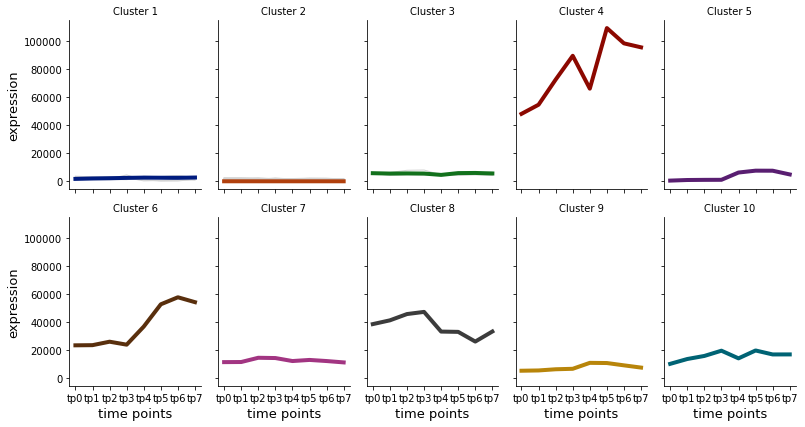

In [ ]:
%matplotlib inline
spy.vis_all_clusters(asclu, col_wrap=5)

## Gene set enrichment analysis

Perform gene set enrichment analysis using `clusters_gsea`. Change the gene_sets parameter into the choice of your knowledge base or gene set database, e.g. Reactome, KEGG, etc. Use `spy.list_genesets` to view the available knowledge base.

In [ ]:
asclu_go, _ = spy.clusters_gsea(flu_dset, 9606, method="gseapy", gene_sets = ['GO_Biological_Process_2018'])

NameError: name 'flu_dset' is not defined

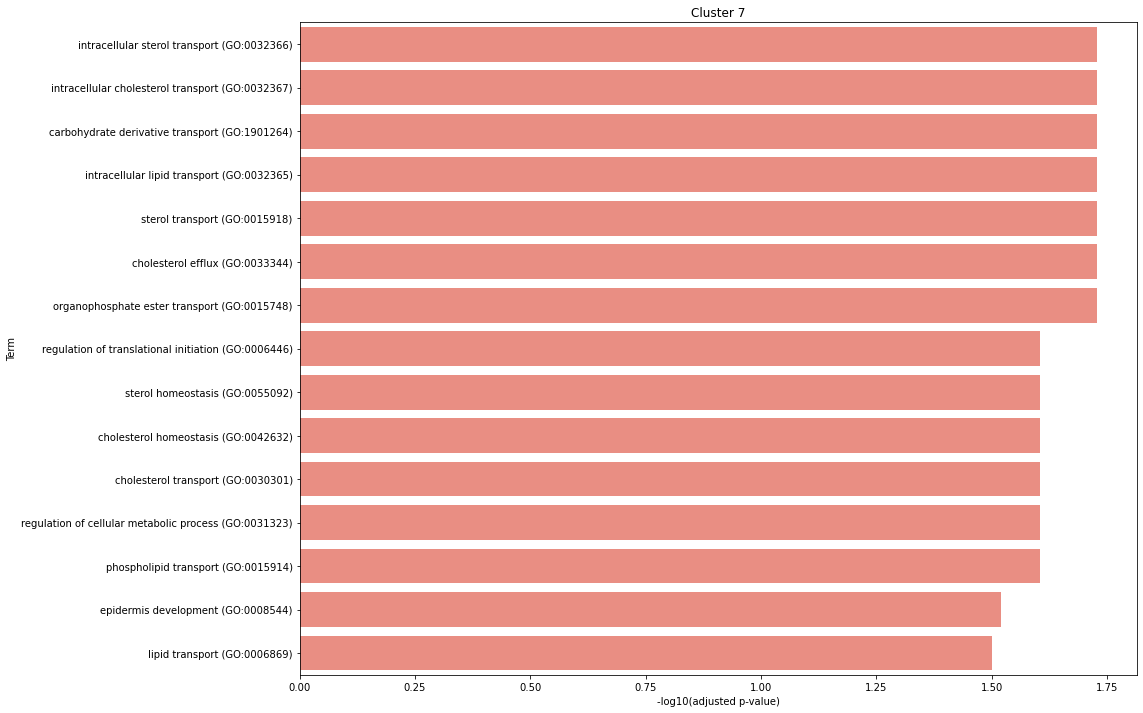

In [ ]:
spy.gsea_plot(asclu_go, cluster=7, nterms=15)

## Run DOMINO

In [ ]:
mods = spy.run_domino(asclu, network_file=bionet, output_file_path="./slices/newslices.txt")

start running DOMINO...
---------Network enrichment Result---------

Cluster 1 found 2 module(s).
Cluster 9 found 8 module(s).
Cluster 2 found 4 module(s).
Cluster 8 found 8 module(s).
Cluster 4 found 0 module(s).
Cluster 6 found 4 module(s).
Cluster 5 found 4 module(s).
Cluster 3 found 1 module(s).
Cluster 10 found 1 module(s).
Cluster 7 found 2 module(s).
-----END-----


To visualize the modules, use `vis_modules`. 

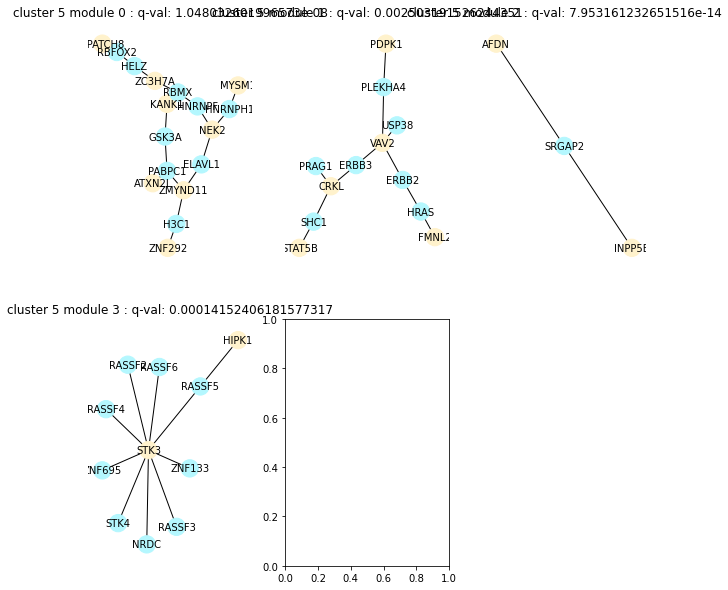

In [ ]:
%matplotlib inline
spy.vis_modules(mods, flu_dset, cluster=5, size=0)

It is also possible to visualize modules with javascript, use `vis_better_modules` and input a desired directory, the function will generate networks with dot format (Graphviz) (https://github.com/pydot/pydot).

vis_better_modules(flu_dset, mods, cluster=5, dir='/path/to/file')